In [1]:
# Importing used packages and model
from cobra.io import read_sbml_model
from cobra import Reaction, Metabolite
model = read_sbml_model('iMT1026-v4.xml')
%run -i create_pathway.ipynb  # runs other script with included function to alter model

In [2]:
with model:
    model2 = model.copy()
    create_pathway(model2,1)

Added beta alanine pathway


In [3]:
model2.reactions.MSADH

Reaction identifier,MSADH
Name,malonate-semialdehyde dehydrogenase
Memory address,0x017d87ae15c0
Stoichiometry,h2o_c + msa_c + nad_c --> h_c + mln_c + nadh_c H2O + 3-Oxopropanoate + NAD+ --> H+ + Malonic acid + NADH
GPR,
Lower bound,0.0
Upper bound,1000.0


In [4]:
# Realistic methanol uptake rates cf.Tomàs‐Gamisans 2018
medium = model2.medium
medium['Ex_meoh'] = 6
medium['Ex_glyc'] = 0
model2.medium = medium
model2.objective = model2.reactions.Ex_mln
solution = model2.optimize()

***Knockout other msa consuming reaction***

In [5]:
#Fva of malonic-semialdehyde at 50% growth
from cobra.flux_analysis import flux_variability_analysis
with model2:
    
    model2.objective = model.reactions.Ex_biomass 
    specified_growth_rate = 0.5*model2.optimize().objective_value


    constrained_growth = model2.problem.Constraint(
        model2.reactions.get_by_id('Ex_biomass').flux_expression,
        lb=specified_growth_rate,
        ub=specified_growth_rate)
    model2.add_cons_vars(constrained_growth)
    
    model2.objective = model2.reactions.Ex_mln
    solution = model2.optimize()
    print(model2.metabolites.msa_c.summary(fva=1.0))

msa_c
=====
Formula: C3H3O3

Producing Reactions
-------------------
Percent  Flux           Range Reaction                           Definition
100.00% 1.173  [1.145; 1.173]   APAT2r  akg_c + ala_B_c --> glu_L_c + msa_c

Consuming Reactions
-------------------
Percent     Flux             Range Reaction                                          Definition
  2.36% -0.02768     [-0.02768; 0]   MMSAD3  coa_c + msa_c + nad_c --> accoa_c + co2_c + nadh_c
 97.64%   -1.145  [-1.145; -1.145]    MSADH      h2o_c + msa_c + nad_c --> h_c + mln_c + nadh_c


In [6]:
model2.reactions.MMSAD3

Reaction identifier,MMSAD3
Name,methylmalonate-semialdehyde dehydrogenase (malonic semialdehyde)
Memory address,0x017d876a0cf8
Stoichiometry,coa_c + msa_c + nad_c --> accoa_c + co2_c + nadh_c CoA + 3-Oxopropanoate + NAD+ --> Acetyl-CoA + CO2 + NADH
GPR,
Lower bound,0.0
Upper bound,1000.0


<AxesSubplot:xlabel='Ex_biomass'>

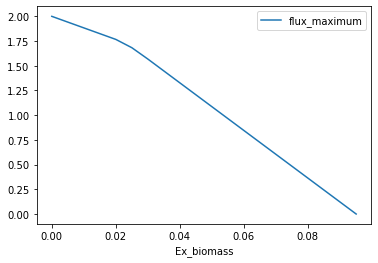

In [7]:
# Knockout MMSAD3 to discover influence on phenotypic phase plane
model2.reactions.MMSAD3.upper_bound=0
from cobra.flux_analysis.phenotype_phase_plane import production_envelope
prod_env = production_envelope(model2, ["Ex_biomass"], objective="Ex_mln", carbon_sources="Ex_meoh")
prod_env.plot(x='Ex_biomass',y='flux_maximum')

***Adding another msa-producing reaction***

In [10]:
# β-alanine-pyruvate aminotransferase from B. cerus
new_reaction = Reaction('BABAT')
new_reaction.add_metabolites({model2.metabolites.pyr_c: -1,
                              model2.metabolites.ala_B_c: -1,
                              model2.metabolites.ala_L_c: 1,
                              model2.metabolites.msa_c: 1,
                             })
model2.add_reactions([new_reaction])

In [11]:
model2.reactions.BABAT

Reaction identifier,BABAT
Name,
Memory address,0x017d8a258828
Stoichiometry,ala_B_c + pyr_c --> ala_L_c + msa_c beta-Alanine + Pyruvate --> L-Alanine + 3-Oxopropanoate
GPR,
Lower bound,0.0
Upper bound,1000.0


<AxesSubplot:xlabel='Ex_biomass'>

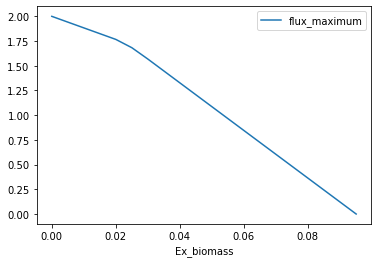

In [12]:
prod_env2 = production_envelope(model2, ["Ex_biomass"], objective="Ex_mln", carbon_sources="Ex_meoh")
prod_env2.plot(x='Ex_biomass',y='flux_maximum')

In [13]:
#Fva of malonic-semialdehyde at 50% growth
with model2:
    
    model2.objective = model.reactions.Ex_biomass 
    specified_growth_rate = 0.5*model2.optimize().objective_value


    constrained_growth = model2.problem.Constraint(
        model2.reactions.get_by_id('Ex_biomass').flux_expression,
        lb=specified_growth_rate,
        ub=specified_growth_rate)
    model2.add_cons_vars(constrained_growth)
  
    
    model2.objective = model2.reactions.Ex_mln
    solution = model2.optimize()
    print(model2.metabolites.msa_c.summary(fva=1.0))

msa_c
=====
Formula: C3H3O3

Producing Reactions
-------------------
Percent    Flux       Range Reaction                           Definition
 96.86%   1.109  [0; 1.145]   APAT2r  akg_c + ala_B_c --> glu_L_c + msa_c
  3.14% 0.03597  [0; 1.145]    BABAT  ala_B_c + pyr_c --> ala_L_c + msa_c

Consuming Reactions
-------------------
Percent   Flux             Range Reaction                                      Definition
100.00% -1.145  [-1.145; -1.145]    MSADH  h2o_c + msa_c + nad_c --> h_c + mln_c + nadh_c
